# **Load the Dataset** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/training_set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_df.csv')

print(f'Number of Rows: {len(train_df)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of Rows: 12000


# **Libraries and Preprocessing** 

In [ ]:
genres_corresp = ((("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism",
                    "Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime", "Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Mystery")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Classics", "Contemporary", "Poetry", "Plays", "Nonfiction", "Autobiography", 
                    "Biography", "Historical", "History", "War", "Mythology"), #-->
                   ("NonFiction")))

genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}

In [3]:
!pip install swifter
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install tensorflow tensorflow_hub tensorflow_text
!pip install top2vec[sentence_transformers]

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter
import umap
import keras

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Classification
from sklearn.svm import SVC
from sklearn import  svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from bs4 import BeautifulSoup
from top2vec import Top2Vec

In [ ]:
# cleaning different patterns
def clean_tokens(tokens):
    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub('\d\s*star[s]?', '', tokens) # removing ratings from reviews
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub('\S*\d+\S*', '', tokens) # removing words with still numbers inside
    tokens = re.sub("(.)\1{2,}", r"\1", tokens) #removing extra characters
    tokens = re.sub("[.,'!]\s(\b)", r"\1", tokens) #removing punctuation that was left without words
    tokens = re.sub("^[.,]\s", '', tokens) #removing punctuation at the start of the line if present
    tokens = re.sub("[.,]\s?$", '', tokens) #removing punctuation at the end of the line if present
    tokens = re.sub(r'([.,])(\S)', r'\1 \2', tokens) # adding a space after punctuation
    tokens = re.sub("(\s){1,}", r"\1", tokens) #removing extra spaces
    token = re.sub(r"\s([.,!])", r"\1", tokens) # removing spaces before punctuation
    token = re.sub(r"([.,]){1,}", r"\1", tokens) # removing extra commas and dots
    token = re.sub(r"\s('[mst])", r"\1", tokens) # removing spaces before the apostrophe
    
    return tokens.strip().lower()

In [ ]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [ ]:
def get_wordnet_pos(treebank_tag):
    """
    To interpret the postag to wordnet lexicon
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos)

        lemmatized_row.append(lemma)

    return lemmatized_row

In [ ]:
def lemmatization(clean_review):
    tokenized_review = word_tokenize(clean_review)
    postagged_review = nltk.pos_tag(tokenized_review)
    postagged_review_for_lemma = [(tup[0], get_wordnet_pos(tup[1])) if len(tup) == 2 else tup for tup in postagged_review]
    lemmatized_review = lemmatize_row([tup for tup in postagged_review_for_lemma if len(tup[0]) > 2])
    return lemmatized_review

In [ ]:
# loading and preprocessing the test set
test_df = pd.read_csv('gr_test_set.csv', usecols=['review_text', 'genre', 'book_id']).dropna().reset_index(drop=True)
test_df = test_df[test_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
test_df.genre = test_df.genre.map(lambda genere: genres_to_keep_dict[genere])
test_df['review_text'] = test_df.review_text.swifter.apply(lambda x: clean_tokens(x))

print(f'Number of Rows: {len(test_df)}')
     

Pandas Apply:   0%|          | 0/373300 [00:00<?, ?it/s]

Number of Rows: 373300


In [ ]:
test_df['lemmatized_text'] = test_df.review_text.swifter.apply(lambda x: lemmatization(x))

Pandas Apply:   0%|          | 0/373300 [00:00<?, ?it/s]

In [6]:
import ast
train_df['lemmatized_joined'] = train_df['lemmatized_text'].transform(lambda x: ' '.join(ast.literal_eval(x)))
train_df.head()

,review_text,genre,rating,book_id,lemmatized_text,lemmatized_joined
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"['breezy', 'hijinks', 'fun', 'read', 'think', ...",breezy hijinks fun read think finish sitting a...
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"['story', 'artwork', 'know', 'best', 'best', '...",story artwork know best best come later rejuve...
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"['rat', 'queen', 'rat', 'queen', 'fight', 'man...",rat queen rat queen fight man kidnap bernardet...
3,i knew nothing about eternals before reading t...,Art,2,47694,"['know', 'eternals', 'read', 'pretty', 'get', ...",know eternals read pretty get neil gaiman know...
4,"better than the last book, this one moves the ...",Art,3,12137592,"['good', 'book', 'move', 'plot', 'forward', 'n...",good book move plot forward ntroduces dead pre...


In [7]:
test_df['lemmatized_joined'] = test_df['lemmatized_text'].transform(lambda x: ' '.join(ast.literal_eval(x)))
test_df.head()

,book_id,review_text,genre,lemmatized_text,lemmatized_joined
0,7092507,alert this is definitely one of my favorites a...,Fiction,"['alert', 'this', 'definitely', 'one', 'favori...",alert this definitely one favorite among the f...
1,5576654,alert you are what you drink. i'm a huge fan o...,Fiction,"['alert', 'you', 'be', 'what', 'you', 'drink',...",alert you be what you drink huge fan coffee bu...
2,15754052,roar is one of my favorite characters in under...,Fiction,"['roar', 'one', 'favorite', 'character', 'unde...",roar one favorite character under the never sk...
3,17020,alert if you feel like travelling to europe an...,Fiction,"['alert', 'you', 'feel', 'like', 'travel', 'eu...",alert you feel like travel europe and you n't ...
4,12551082,i read and enjoyed the first two novels from t...,Fiction,"['read', 'and', 'enjoy', 'the', 'first', 'two'...",read and enjoy the first two novel from this s...


In [ ]:
test_df = test_df.sample(frac=0.1)
len(test_df)

37330

In [ ]:
test_df.to_csv('test_df_sample.csv', index = False)

## **Genre Classification: LSTM, SVM and Naive Bayes**

In this part, we'll try different embeddings and strategies to get interesting results. We will proceed this way due to the fact that, for the 'genre' classification task, we found it difficult to get good performance for the validation set. Trying to overcome this problem, in this section we will try, both for LSTM, SVM and Naive Bayes:



*   **Tokenizer** (provided from Keras, in general used for deep neural networks)
*   **CountVectorizer** 
*   **CountVectorizer with Umap Reduction**
*   **Tf-idf** 
*   **Tf-idf with Umap Reduction**
*   **Top2Vec** creating a new filtered column based on words similar to the different genre classes





In [8]:
train = train_df['lemmatized_joined']
test = test_df['lemmatized_joined']
y = train_df['genre']
# encoding labels
Y = pd.get_dummies(y)

In [19]:
# encoding label for svm,naive
Encoder = LabelEncoder()
Yt = Encoder.fit_transform(train_df['genre'])
Ytest = Encoder.fit_transform(test_df['genre'])

### **Tokenizer**

In [ ]:
def cust_tokenizer(num_words, col):
  tokenizer = Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts(col)
  X = tokenizer.texts_to_sequences(col)
  word_index = tokenizer.word_index
  # check the max len in order to use this value later (for parameter 'input_length' of the model and for pad_sequence)
  maxim = max([len(x) for x in X])
  return X, word_index, maxim

In [ ]:
X = cust_tokenizer(20000, train)
print('There are {} unique tokens and the maximum sequence length is {}.'.format(len(X[1]), X[2]))

There are 43024 unique tokens and the maximum sequence length is 180.


In [ ]:
# for creating vector of same length
Xp = pad_sequences(X[0], maxlen=X[2])

In [ ]:
# The maximum number of words to be used, i.e. the the most frequent.
max_nwords = 20000
# Maximum number of words in each complaint.
max_seq_len = 180
# Fixed value
embedd_dim = 60

In [ ]:
# creation of the model
model = Sequential()
model.add(Embedding(max_nwords, embedd_dim, input_length=max_seq_len))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation = 'softmax', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(18, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.add(Dropout(0.2))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 180, 60)           1200000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 180, 256)         193536    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 180, 256)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 18)               

After testing different models with different layers and different optimizers, we chose a learning rate of 0.001 to keep the loss lower (although the loss is always similar in the other cases).

In [ ]:
epochs = 6
batch_size = 128
history = model.fit(Xp, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])

Epoch 1/6
66/66 [==============================] - 152s 2s/step - loss: 0.8513 - accuracy: 0.2373 - val_loss: 0.5234 - val_accuracy: 0.0000e+00
Epoch 2/6
66/66 [==============================] - 135s 2s/step - loss: 0.8656 - accuracy: 0.2385 - val_loss: 0.5497 - val_accuracy: 0.0000e+00
Epoch 3/6
66/66 [==============================] - 115s 2s/step - loss: 0.8590 - accuracy: 0.2321 - val_loss: 0.5727 - val_accuracy: 0.0000e+00
Epoch 4/6
66/66 [==============================] - 115s 2s/step - loss: 0.8614 - accuracy: 0.2350 - val_loss: 0.5971 - val_accuracy: 0.0000e+00
Epoch 5/6
66/66 [==============================] - 112s 2s/step - loss: 0.8461 - accuracy: 0.2382 - val_loss: 0.6228 - val_accuracy: 0.0000e+00


For computational reasons, we reduce the value of the num_words parameter of Tokenizer to 5000 only for SVM (with 20000 words it takes a lot of time).

In [ ]:
X = cust_tokenizer(5000, train)
Xp = pad_sequences(X[0])

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(Xp,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='rbf', degree=6, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(degree=6, gamma='auto')


SVM Accuracy Score --->  15.833333333333332


In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
# comparing real values with predicted values  
print("Train accuracy(in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy(in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy(in %): 20.42857142857143
Validation accuracy(in %): 16.86111111111111


As expected, since the Tokenizer is a technique used especially for deep neural networks, we have bad performance and even using 20000 or 5000 words for the Tokenizer, the performance does not improve.

### **CountVectorizer**

In [11]:
vectorizer = CountVectorizer(min_df=2, max_features=20000)
word_doc_matrix = vectorizer.fit_transform(train)

In [ ]:
# for padding we have to reduce dimensionality of the matrix
from sklearn.decomposition import TruncatedSVD        
pca = TruncatedSVD(n_components=6)                                
X_reduced_train = pca.fit_transform(word_doc_matrix)  

In [ ]:
Xp = pad_sequences(X_reduced_train)
Xp.shape

(12000, 6)

In [ ]:
# The maximum number of words to be used. (most frequent)
max_nwords = 20000
# Max number of words in each complaint.
max_seq_length = 6
embedding_dim = 6

In [ ]:
model = Sequential()
model.add(Embedding(max_nwords, embedding_dim, input_length=max_seq_length))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation = 'sigmoid')))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.add(Dropout(0.2))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 6, 6)              120000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 200)              85600     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 6)                 1206      
                                                                 
 dropout_21 (Dropout)        (None, 6)                 0         
                                                                 
Total params: 206,806
Trainable params: 206,806
Non-trainable params: 0
________________________________________________

In [ ]:
epochs = 5
batch_size = 128
history = model.fit(Xp, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/5
66/66 [==============================] - 10s 70ms/step - loss: 0.8292 - accuracy: 0.2438 - val_loss: 0.8871 - val_accuracy: 0.0000e+00
Epoch 2/5
66/66 [==============================] - 4s 62ms/step - loss: 0.8163 - accuracy: 0.2468 - val_loss: 0.9134 - val_accuracy: 0.0000e+00
Epoch 3/5
66/66 [==============================] - 4s 62ms/step - loss: 0.8282 - accuracy: 0.2576 - val_loss: 0.9364 - val_accuracy: 0.0000e+00
Epoch 4/5
66/66 [==============================] - 4s 60ms/step - loss: 0.8278 - accuracy: 0.2801 - val_loss: 0.9685 - val_accuracy: 0.0000e+00
Epoch 5/5
66/66 [==============================] - 4s 62ms/step - loss: 0.8454 - accuracy: 0.2815 - val_loss: 0.9770 - val_accuracy: 0.0000e+00


In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(word_doc_matrix,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=6, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, degree=6, gamma='auto')


SVM Accuracy Score ---> 31.75


In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
# comparing real values with predicted values  
print("Train accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy for Naive Bayes (in %): 94.48809523809524
Validation accuracy for Naive Bayes (in %): 72.97222222222223


In this case, a *higher value of num_words for CountVectorizer improves the performance only for Naive Bayes* (with 20000 we have good scores, but if we lower the num_words value the perfomance decreases), instead maintaining a *lower performance for LSTM* and an *increase for SVM score* compared to the previous case.

### **CountVectorizer + Umap reduction**

In the Preprocessing section we have seen a Umap plot in which the classes appears well divided. So here we will see if there are any differences in the scores using a *Umap reduction*. 

First, we will try to use the default value of Umap function of **n_component (=2)**, then we will try to increase this value. 

In [9]:
def umap_reduction(matrix, component=False):
  reducer = umap.UMAP().fit(matrix) if component == False else umap.UMAP(n_components=component).fit(matrix)
  embedding = reducer.fit_transform(matrix)
  return embedding

In [ ]:
embedding = umap_reduction(word_doc_matrix)

In [ ]:
X = pad_sequences(embedding)
# The maximum number of words to be used. (most frequent)
max_nwords = 20000
# Max number of words in each complaint.
max_seq_length = 2
embedding_dim = 2

In [ ]:
model = Sequential()
model.add(Embedding(max_nwords, embedding_dim, input_length=max_seq_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation = 'sigmoid')))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.add(Dropout(0.2))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 2, 2)              40000     
                                                                 
 bidirectional_13 (Bidirecti  (None, 256)              134144    
 onal)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 6)                 1542      
                                                                 
 dropout_27 (Dropout)        (None, 6)                 0         
                                                                 
Total params: 175,686
Trainable params: 175,686
Non-trainable params: 0
________________________________________________

In [ ]:
epochs = 10
batch_size = 64
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
132/132 [==============================] - 9s 33ms/step - loss: 0.8356 - accuracy: 0.2382 - val_loss: 0.9137 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 4s 27ms/step - loss: 0.8368 - accuracy: 0.2676 - val_loss: 0.9802 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 4s 27ms/step - loss: 0.8297 - accuracy: 0.3120 - val_loss: 0.9993 - val_accuracy: 0.0000e+00
Epoch 4/10
132/132 [==============================] - 3s 26ms/step - loss: 0.8258 - accuracy: 0.3243 - val_loss: 1.0222 - val_accuracy: 0.0000e+00


In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, gamma='auto')


SVM Accuracy Score --->  32.361111111111114


For running Naive Bayes, we use the padding version because the Umap reduction also gives negative values which are not accepted by the Naive classifier (and we get a lower score for that).

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(X,Yt,test_size=0.3)

In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
  
# comparing real values with predicted values  
print("Train accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy for Naive Bayes (in %): 22.952380952380953
Validation accuracy for Naive Bayes (in %): 22.805555555555557


In general, with CountVectorizer + Umap we have seen a decrease in the performance of Naive Bayes. SVM maintained the same accuracy and the LSTM score increased slightly.

Now let's see with **6 components** if there are differences from the default 2 components:

In [12]:
# take the matrix defined above woth CountVectorizer
embedding = umap_reduction(word_doc_matrix, 6)

In [13]:
X = pad_sequences(embedding)
max_nwords = 20000
max_seq_length = 6
embedding_dim = 5

In [14]:
model = Sequential()
model.add(Embedding(max_nwords, embedding_dim, input_length=max_seq_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation = 'sigmoid')))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.add(Dropout(0.2))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 5)              100000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              137216    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
Total params: 238,758
Trainable params: 238,758
Non-trainable params: 0
__________________________________________________

In [15]:
epochs = 10
batch_size = 64
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
132/132 [==============================] - 34s 195ms/step - loss: 0.8317 - accuracy: 0.2460 - val_loss: 0.9502 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 12s 88ms/step - loss: 0.8337 - accuracy: 0.3076 - val_loss: 0.9637 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 9s 71ms/step - loss: 0.8338 - accuracy: 0.3506 - val_loss: 1.0076 - val_accuracy: 0.0000e+00
Epoch 4/10
132/132 [==============================] - 9s 67ms/step - loss: 0.7978 - accuracy: 0.3669 - val_loss: 1.0380 - val_accuracy: 0.0000e+00
Epoch 5/10
132/132 [==============================] - 12s 90ms/step - loss: 0.8186 - accuracy: 0.3746 - val_loss: 1.0670 - val_accuracy: 0.0000e+00
Epoch 6/10
132/132 [==============================] - 15s 113ms/step - loss: 0.8072 - accuracy: 0.3868 - val_loss: 1.0835 - val_accuracy: 0.0000e+00


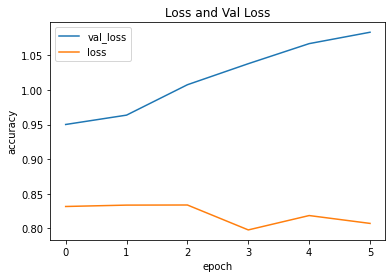

In [16]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss and Val Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

Using a value of 5 for Patience, the model *stops at epoch 6.* As seen in the plot, and as seen in all cases observed, *the val loss *has the same trend and, in general, it *never decreases* and a high score is never obtained.

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, gamma='auto')


SVM Accuracy Score ---> 53.861111111111114


In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(X,Yt,test_size=0.3)

In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
  
# comparing real values with predicted values  
print("Train accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy for Naive Bayes (in %): 31.19047619047619
Validation accuracy for Naive Bayes (in %): 30.75


Using 6 components we have a greater perfomance for **LSTM (from 32% to 42%)** and in particular for **SVM (from 32% to 54%).**

### **Tf-idf** 

In [17]:
Tfidf_vect = TfidfVectorizer(max_features=20000)
TrainTDF = Tfidf_vect.fit_transform(train)

In [ ]:
# need reduction for padding
pca = TruncatedSVD(n_components=6)                                
X_reduced_train = pca.fit_transform(TrainTDF)  

In [ ]:
X = pad_sequences(X_reduced_train)
X.shape

(12000, 6)

In [ ]:
model = Sequential()
model.add(Embedding(max_nwords, embedding_dim, input_length=max_seq_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation = 'softmax')))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.add(Dropout(0.2))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 6, 5)              100000    
                                                                 
 bidirectional_26 (Bidirecti  (None, 256)              137216    
 onal)                                                           
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 1542      
                                                                 
 dropout_53 (Dropout)        (None, 6)                 0         
                                                                 
Total params: 238,758
Trainable params: 238,758
Non-trainable params: 0
_______________________________________________

In [ ]:
epochs = 10
batch_size = 128
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
66/66 [==============================] - 10s 77ms/step - loss: 0.8845 - accuracy: 0.2389 - val_loss: 0.4836 - val_accuracy: 0.0000e+00
Epoch 2/10
66/66 [==============================] - 5s 71ms/step - loss: 0.8619 - accuracy: 0.2335 - val_loss: 0.5163 - val_accuracy: 0.0000e+00
Epoch 3/10
66/66 [==============================] - 5s 69ms/step - loss: 0.8704 - accuracy: 0.2302 - val_loss: 0.5508 - val_accuracy: 0.0000e+00
Epoch 4/10
66/66 [==============================] - 5s 69ms/step - loss: 0.8541 - accuracy: 0.2423 - val_loss: 0.5886 - val_accuracy: 0.0000e+00
Epoch 5/10
66/66 [==============================] - 4s 67ms/step - loss: 0.8578 - accuracy: 0.2293 - val_loss: 0.6248 - val_accuracy: 0.0000e+00
Epoch 6/10
66/66 [==============================] - 4s 67ms/step - loss: 0.8529 - accuracy: 0.2304 - val_loss: 0.6548 - val_accuracy: 0.0000e+00


In [20]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(TrainTDF,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=6, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))


SVC(C=2.0, degree=6, gamma='auto')


SVM Accuracy Score --->  15.666666666666668


In [21]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [22]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
  
# comparing real values with predicted values  
print("Train accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy for Naive Bayes (in %): 95.64285714285714
Validation accuracy for Naive Bayes (in %): 71.27777777777777


In [24]:
print(classification_report(Yval, y_pred, target_names=train_df['genre'].unique()))

                 precision    recall  f1-score   support

            Art       0.92      0.88      0.90       609
        Fiction       0.56      0.45      0.50       630
        Mystery       0.70      0.65      0.68       597
     NonFiction       0.71      0.70      0.70       589
        Romance       0.64      0.81      0.72       596
Science Fiction       0.74      0.80      0.77       579

       accuracy                           0.71      3600
      macro avg       0.71      0.72      0.71      3600
   weighted avg       0.71      0.71      0.71      3600



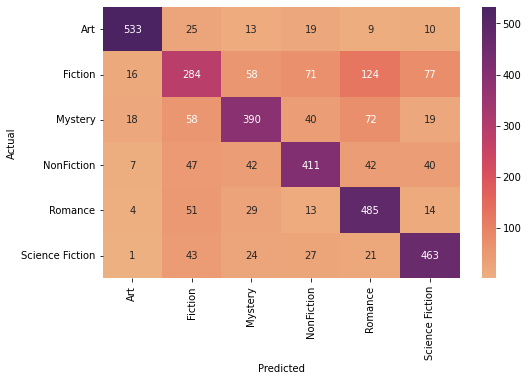

In [27]:
# confusion matrix
cm = confusion_matrix(Yval, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, xticklabels=train_df['genre'].unique(), yticklabels=train_df['genre'].unique(), fmt='d', annot=True, cmap=sns.color_palette("flare", as_cmap=True))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Tf-idf values seems not so good for SVM as they are for Naive Bayes.

But if we take the reduced version of Tf-idf (with 6 components) for the SVM model we get a higher score:

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(X_reduced_train,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=6, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))


SVC(C=2.0, degree=6, gamma='auto')


SVM Accuracy Score --->  40.91666666666667


### **Tf-idf + Umap reduction**

Here we use directly 6 components for Umap reduction:

In [ ]:
embedding = umap_reduction(TrainTDF,6)

In [ ]:
X = pad_sequences(embedding)
max_nwords = 20000
max_seq_length = 6
embedding_dim = 5

In [ ]:
epochs = 5
batch_size = 128
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
66/66 [==============================] - 5s 72ms/step - loss: 0.8322 - accuracy: 0.2381 - val_loss: 0.6516 - val_accuracy: 0.0000e+00
Epoch 2/5
66/66 [==============================] - 5s 72ms/step - loss: 0.8372 - accuracy: 0.2374 - val_loss: 0.6791 - val_accuracy: 0.0000e+00
Epoch 3/5
66/66 [==============================] - 5s 71ms/step - loss: 0.8451 - accuracy: 0.2374 - val_loss: 0.7005 - val_accuracy: 0.0000e+00
Epoch 4/5
66/66 [==============================] - 5s 72ms/step - loss: 0.8389 - accuracy: 0.2401 - val_loss: 0.7180 - val_accuracy: 0.0000e+00


In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
from sklearn.svm import SVC
from sklearn import  svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=6, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))


SVC(C=2.0, degree=6, gamma='auto')


SVM Accuracy Score ---> 51.19444444444444


Even if we tried to change layers, optimizers and dropouts the validation accuracy remains *always low for LSTM (except for CounVectorizer+Umap(6 components)*. Overall, the **best perfomance** we got **for SVM are those in relation to UMAP reduction**, while **for Naive Bayes** we get **higher scores withouth UMAP reduction**.

# **Top2Vec**

The idea comes again from the observation of the UMAP plot in the "Preprocessing" section where, by recognizing the different topics, it is possible to see a situation in which the different classes seem to be distinguishable.

As Top2Vec helps us in finding topics in our corpus, in this section *we try to use Top2Vec to found words that are **semantically "similar" to some specified words (in our case, we use only the words of 'genre' classes**)*. Next, we create a new column that's a filtered version of the lemmatized_joined column with only the words that we've previously found similar to the genre classes. 

In this way, we will see if there are any difference for classification. 

In [28]:
# using an embedding model (the only one we can use in our case as the other two avaible model are integrated with foreign languages
model_train = Top2Vec(train.to_numpy(), embedding_model='universal-sentence-encoder')

2022-12-10 17:57:49,316 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-12-10 17:57:51,980 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2022-12-10 17:58:42,355 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-12-10 17:58:50,077 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-12-10 17:59:14,490 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-12-10 17:59:15,033 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_train.get_num_topics()

25

In [ ]:
topic_words, word_scores, topic_nums = model_train.get_topics(2)
topic_words

array([['subplot', 'novel', 'trope', 'intrigue', 'erotica',
        'predictable', 'scalzi', 'povs', 'cliche', 'novella',
        'worldbuilding', 'protagonist', 'prose', 'storytelling',
        'suspense', 'plot', 'blurb', 'goodreads', 'romance', 'austen',
        'quirky', 'gritty', 'literary', 'frustrate', 'tedious', 'climax',
        'writing', 'suspenseful', 'character', 'intriguing', 'genre',
        'pacing', 'storyline', 'book', 'shallow', 'whiny', 'horror',
        'prologue', 'retelling', 'write', 'gaiman', 'compelling',
        'heroine', 'trilogy', 'boring', 'dialogue', 'narration',
        'likable', 'angst', 'likeable'],
       ['nonfiction', 'subplot', 'novel', 'narrative', 'storytelling',
        'narration', 'trope', 'dystopian', 'worldbuilding', 'dramatic',
        'fiction', 'protagonist', 'conflict', 'scalzi', 'intrigue',
        'prejudice', 'tragedy', 'postapocalyptic', 'novella', 'dystopia',
        'horror', 'literary', 'wwii', 'hero', 'angst', 'povs', 'war',
  

In [29]:
def create_topics_words(mod,lista, num_word):
  l = []
  for i in range(len(lista)):
    # the function model.similar_words returns both the words and the words scores, so we take only the first output
    l += [wo for wo in [w for w in mod.similar_words(keywords=[lista[i]],num_words=num_word)[0] if w not in l]]
  return l

In [ ]:
# list containing the 200 words similar for each genre (withouth duplicates)
train_words_sim2 = create_topics_words(model_train, ['Art','Romance','Reality','Science','Mystery','Fiction'], 200)

In [30]:
# list containing the 500 words similar for each genre (withouth duplicates)
train_words_sim5 = create_topics_words(model_train, ['Art','Romance','Reality','Science','Mystery','Fiction'], 500)

In [31]:
def maintain_some_words(x, l):
  lists = [word for word in x if word in l]
  return lists

In [32]:
train_df['lemmatized_text'] = train_df['lemmatized_text'].apply(lambda x: ast.literal_eval(x))
train_df.head()

,review_text,genre,rating,book_id,lemmatized_text,lemmatized_joined
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"[breezy, hijinks, fun, read, think, finish, si...",breezy hijinks fun read think finish sitting a...
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"[story, artwork, know, best, best, come, later...",story artwork know best best come later rejuve...
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"[rat, queen, rat, queen, fight, man, kidnap, b...",rat queen rat queen fight man kidnap bernardet...
3,i knew nothing about eternals before reading t...,Art,2,47694,"[know, eternals, read, pretty, get, neil, gaim...",know eternals read pretty get neil gaiman know...
4,"better than the last book, this one moves the ...",Art,3,12137592,"[good, book, move, plot, forward, ntroduces, d...",good book move plot forward ntroduces dead pre...


First we analyze the case where we take only the 200 similar words for each genre, then for each record, from the lemmatized_text column, we check if each word is in the similar words list and, if so, we add it in the new "topic_words" column.

In [ ]:
train_df['topic_words'] = train_df['lemmatized_text'].apply(lambda x: maintain_some_words(x,train_words_sim2))

In [ ]:
train_df.head()

,review_text,genre,rating,book_id,lemmatized_text,lemmatized_joined,topic_words,topic_words_2
0,"breezy hijinks, fun to read. think i finished ...",Art,3,22718721,"[breezy, hijinks, fun, read, think, finish, si...",breezy hijinks fun read think finish sitting a...,"[fun, author, feel, shit, gender, piece, woman...","[fun, author, feel, shit, gender, piece, woman..."
1,"for the story, for the artwork. you know how t...",Art,2,13533744,"[story, artwork, know, best, best, come, later...",story artwork know best best come later rejuve...,"[story, artwork, know, new, comic, amazing, su...","[story, artwork, know, new, comic, amazing, su..."
2,rat queens so the rat queens are to fight the ...,Art,3,23012877,"[rat, queen, rat, queen, fight, man, kidnap, b...",rat queen rat queen fight man kidnap bernardet...,"[man, draw, artist, artist, mature, lady, kind...","[man, draw, artist, artist, mature, lady, kind..."
3,i knew nothing about eternals before reading t...,Art,2,47694,"[know, eternals, read, pretty, get, neil, gaim...",know eternals read pretty get neil gaiman know...,"[know, gaiman, know, series, know, character, ...","[know, gaiman, know, series, know, character, ..."
4,"better than the last book, this one moves the ...",Art,3,12137592,"[good, book, move, plot, forward, ntroduces, d...",good book move plot forward ntroduces dead pre...,"[book, plot, dead, government, interesting, th...","[book, plot, dead, government, interesting, th..."


In [ ]:
newtrain = train_df['topic_words'].apply(lambda x: ' '.join(x))

### **CountVectorizer**

In [ ]:
vectorizer = CountVectorizer(min_df=2, max_features=20000)
word_doc_matrix = vectorizer.fit_transform(newtrain)

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(word_doc_matrix,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=4.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Yval)*100)

SVC(C=4.0, gamma='auto')

SVM Accuracy Score ->  55.166666666666664


**By selecting 200 similar words** for each genre and using them for classification, **SVM accuracy increases to 58%**, using CountVectorizer alone. **Using instead 500 similar words** for each genre, the **SVM accuracy reaches 61%** as shown below.

In [33]:
train_df['topic_words_2'] = train_df['lemmatized_text'].apply(lambda x: maintain_some_words(x,train_words_sim5))

In [34]:
newtrain2 = train_df['topic_words_2'].apply(lambda x: ' '.join(x))

In [35]:
vectorizer = CountVectorizer(min_df=2, max_features=20000)
word_doc_matrix = vectorizer.fit_transform(newtrain2)

In [36]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(word_doc_matrix,Yt,test_size=0.3)

In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
# comparing real values with predicted values  
print("Train accuracy for Naive (in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy for Naive (in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy for Naive (in %): 71.91666666666666
Validation accuracy for Naive (in %): 63.66666666666667


In [37]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=5.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ----> {}".format(accuracy_score(predictions_SVM, Yval)*100))



SVM Accuracy Score ----> 61.33333333333333


In [39]:
print(classification_report(Yval, predictions_SVM, target_names=train_df['genre'].unique()))

                 precision    recall  f1-score   support

            Art       0.86      0.80      0.83       618
        Fiction       0.42      0.42      0.42       590
        Mystery       0.61      0.55      0.58       600
     NonFiction       0.55      0.63      0.59       586
        Romance       0.61      0.68      0.64       598
Science Fiction       0.63      0.60      0.61       608

       accuracy                           0.61      3600
      macro avg       0.62      0.61      0.61      3600
   weighted avg       0.62      0.61      0.61      3600



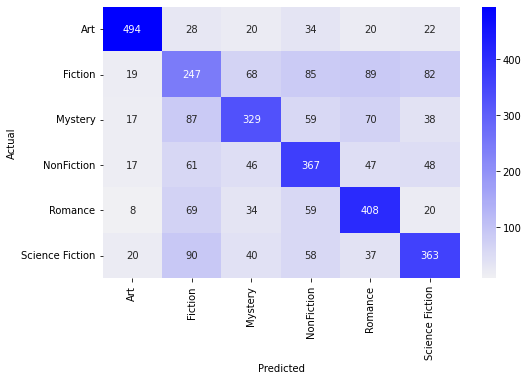

In [38]:
cm = confusion_matrix(Yval, predictions_SVM)
plt.figure(figsize=(8,5))
sns.heatmap(cm, xticklabels=train_df['genre'].unique(), yticklabels=train_df['genre'].unique(), fmt='d', annot=True, cmap=sns.color_palette("light:b", as_cmap=True))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In this case, the class that seems to be predicted the better is "*Art*" and, conversely, the class predicted the worse is "*Fiction"*, as seen also before.

### **Countvectorizer + Umap**

In [ ]:
embedding = umap_reduction(word_doc_matrix)

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ----> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, gamma='auto')


SVM Accuracy Score ----> 31.472222222222225


Now, compared to previous results, even if we use a umap reduction the perfomance does not improve so much.

In [ ]:
embedding = umap_reduction(word_doc_matrix,6)

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ----> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, gamma='auto')


SVM Accuracy Score ----> 43.666666666666664


### **Tf-idf** 

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=20000)
TrainTDF = Tfidf_vect.fit_transform(newtrain2)

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(TrainTDF,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=2.0, gamma='auto')


SVM Accuracy Score ---> 23.194444444444446


In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(Xtrain)
y_pred = model_naive.predict(Xval)
# comparing real values with predicted values  
print("Train accuracy(in %): {}".format(metrics.accuracy_score(Ytrain, y_train_pred)*100))
print("Validation accuracy(in %): {}".format(metrics.accuracy_score(Yval, y_pred)*100))

Train accuracy(in %): 72.86904761904762
Validation accuracy(in %): 62.38888888888889


### **Tf-idf + Umap**

In [ ]:
embedding = umap_reduction(TrainTDF,6)

In [ ]:
#Splitting the data into train and test datasets
Xtrain, Xval, Ytrain, Yval = train_test_split(embedding,Yt,test_size=0.3)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=3.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Xtrain,Ytrain)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Xval)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score ---> {}".format(accuracy_score(predictions_SVM, Yval)*100))

SVC(C=3.0, gamma='auto')


SVM Accuracy Score ---> 45.80555555555556


# **Test set**

To see the perfomance of **test set**, in this case we choose only the models that give us better results: *Naive Bayes Classifier* and *SVM*. The test set score for Naive Bayes, taking into account only the Tf-idf case, is not so good as we expected:

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=20000)
TrainTDF = Tfidf_vect.fit_transform(train)
TestTDF = Tfidf_vect.fit_transform(test)

In [ ]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(TrainTDF, Yt)

MultinomialNB(alpha=0.2)

In [ ]:
y_train_pred = model_naive.predict(TrainTDF)
y_pred = model_naive.predict(TestTDF)
  
# comparing real values with predicted values  
print("Train accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Yt, y_train_pred)*100))
print("Test accuracy for Naive Bayes (in %): {}".format(metrics.accuracy_score(Ytest, y_pred)*100))

Train accuracy for Naive Bayes (in %): 93.60833333333333
Validation accuracy for Naive Bayes (in %): 20.718992767211358


For *SVM*, using CountVectorizer + Umap and as input the filtered column with Top2Vec, we obtained the following score:

In [ ]:
model_test = Top2Vec(test.to_numpy(), embedding_model='universal-sentence-encoder')

2022-12-08 01:46:15,763 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-12-08 01:46:28,645 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2022-12-08 01:46:33,141 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-12-08 01:47:09,869 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-12-08 01:47:57,765 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-12-08 01:48:05,647 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
test_df['lemmatized_text'] = test_df['lemmatized_text'].apply(lambda x: ast.literal_eval(x))
test_df.head()

,book_id,review_text,genre,lemmatized_text,lemmatized_joined
228469,13642963,flavia de luce mystery series eleven year old ...,Mystery,"[flavia, luce, mystery, series, eleven, year, ...",flavia luce mystery series eleven year old fla...
10994,16433,i've read four or five odd thomas books thus f...,Mystery,"['ve, read, four, five, odd, thomas, book, thu...",'ve read four five odd thomas book thus far an...
127447,22669832,i read the first of this book when i finally d...,Romance,"[read, the, first, this, book, when, finally, ...",read the first this book when finally decide t...
47935,16068910,"firstly, thanks to harperteen for this earc. r...",Fiction,"[firstly, thanks, harperteen, for, this, earc,...",firstly thanks harperteen for this earc review...
162043,22457959,the series tear asunder is one that i have rea...,Mystery,"[the, series, tear, asunder, one, that, have, ...",the series tear asunder one that have really e...


In [ ]:
# list containing the 500 words similar for each genre (withouth duplicates)
train_words_sim5 = create_topics_words(model_train, ['Art','Romance','Reality','Science','Mystery','Fiction'], 500)
test_words_sim5 = create_topics_words(model_test, ['Art','Romance','Reality','Science','Mystery','Fiction'], 1000)

In [ ]:
test_df['topic_words'] = test_df['lemmatized_text'].apply(lambda x: maintain_some_words(x,test_words_sim5))

In [ ]:
newtest = test_df['topic_words'].apply(lambda x: ' '.join(x))

In [ ]:
vectorizer = CountVectorizer(min_df=2, max_features=20000)
word_doc_matrix = vectorizer.fit_transform(newtrain2)
word_doc_matrix_test = vectorizer.fit_transform(newtest)

In [ ]:
embedding = umap_reduction(word_doc_matrix)
embedding_t = umap_reduction(word_doc_matrix_test)

In [ ]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(embedding,Yt)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(embedding_t)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> {}".format(accuracy_score(predictions_SVM, Ytest)*100))

SVM Accuracy Score ->  55.04420037503348


# **Conclusions**

In general, the best results we get are the following:

*   For **Naive Bayes**, using only CountVectorizer or Tf-Idf, we get roughly a **94% of accuracy in training set and 73% in validation set**.
*   For **SVM**, the best case is obtained with the new column reduced with the most semantically most similar words and using CountVectorizer (reaching a **61% of validation accuracy**). But, in general, in the previous cases it was possible to see a good improvement in accuracy using the Umap Reduction, in particular with a reduction of 6 components (even for 2 components but not so much compared to the latter.
*   For **LSTM**, we didn't find a lower validation loss and, using a Patience parameter, decided to stop using a 3/5 value of Patience. In the analyzed cases, the best case is obtained with CountVectorizer + Umap (**40%**).
*  For Test Set, we took only the models in which we obtained a higher validation accuracy, but obtaining lower scores. 